In [1]:
# gms = s.get_games_season(2024)

# Last run on 3/21

In [2]:
# gms[0].to_csv('NCAAteams.csv', index=False)
# gms[1].to_csv('NCAAplyrs.csv', index=False)
# gms[2].to_csv('NCAApbp.csv', index=False)

In [3]:
# !pip install cbbpy
import cbbpy.mens_scraper as s

In [4]:
# aug = s.get_games_range("2024-01-01", "2024-03-25")
# teamAug = aug[0]
# plyrAug = aug[1]
# pbpAug = aug[2]

In [5]:
# teamAug.to_csv('mar25data/NCAAteams.csv', index=False)
# plyrAug.to_csv('mar25data/NCAAplyrs.csv', index=False)
# pbpAug.to_csv('mar25data/NCAApbp.csv', index=False)

In [6]:
# teamAug[teamAug.game_day == teamAug.game_day[0]].shape

In [7]:
from scipy import stats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

from NCAA_helpers import get_team_games, create_game_data, tm_search,\
    prop_hit, prop_build, prop_pct, regress_prop, regression, process_games, tm_descriptive, build_forest

pd.options.mode.copy_on_write = True

In [8]:
mar23_teams = [("Dayton", "Arizona Wildcats"), ("Gonzaga", "Jayhawks"), ("Michigan State", "Tar Heels"), 
               ("Iowa State", "Washington State"), ("NC State", "Oakland Golden"), ("Texas Longhorns", "Tennessee Volunteers"),
               ("Duquesne", "Illinois Fighting"), ("Oregon Ducks", "Creighton")]

tst = create_game_data(mar23_teams)
mar23sprd = {"Dayton Flyers":9.5,
        "Gonzaga Bulldogs":-4.5,
        "Michigan State Spartans":4.5,
        "Iowa State Cyclones":-6.5,
        "NC State Wolfpack":-6.5,
        "Texas Longhorns":6.5,
        "Duquesne Dukes":10.5,
        "Oregon Ducks":4.5
        }

In [9]:
from NCAA_helpers import team_df

In [10]:
mar24_teams = \
        [("Colorado Buffaloes", "Marquette Golden Eagles"),
         ("Utah State Aggies", "Purdue Boilermakers"),
         ("James Madison Dukes", "Duke Blue Devils"),
         ("Clemson Tigers", "Baylor Bears"),
         ("Grand Canyon Lopes", "Alabama Crimson Tide"),
         ("Northwestern Wildcats", "UConn Huskies"),
         ("Texas A&M Aggies", "Houston Cougars"),
         ("Yale Bulldogs", "San Diego State Aztecs")]

mar24 = create_game_data(mar24_teams)

In [11]:
spreadDict = \
{
    "Oregon Ducks" : 4.5,
    "Colorado Buffaloes" : 3.5,
    "Utah State Aggies" : 11.5,
    "Duke Blue Devils" : -7.5,
    "Baylor Bears" : -4.5,
    "Alabama Crimson Tide" : -5.5,
    "UConn Huskies" : -14.5,
    "Houston Cougars" : -9.5,
    "San Diego State Aztecs" : -5.5
}

In [12]:
sweet16 = \
        [("UConn Huskies", "San Diego State Aztecs"),
         ("Houston Cougars", "Duke Blue Devils"),
         ("Illinois Fighting Illini", "Iowa State Cyclones"),
         ("North Carolina Tar Heels", "Alabama Crimson Tide"),
         ("Clemson Tigers", "Arizona Wildcats"),
         ("Creighton Bluejays", "Tennessee Volunteers"),
         ("Purdue Boilermakers", "Gonzaga Bulldogs"),
         ("NC State Wolfpack", "Marquette Golden Eagles")]

sweetSpread = \
{
        "Clemson Tigers": 6.5,
        "UConn Huskies": -10.5,
        "Alabama Crimson Tide": 4.5,
        "Iowa State Cyclones": -1.5,
        "NC State Wolfpack": 6.5,
        "Gonzaga Bulldogs": 5.5,
        "Houston Cougars": -3.5,
        "Creighton Bluejays": 2.5
}

In [13]:
sweetData = create_game_data(sweet16)

In [14]:
# process_games(sweetData, spreadDict=sweetSpread, outputLocation="sweet16")

In [15]:
sweetData[0].keys()
Uconn = sweetData[0]["UConn Huskies"]["team"]
SDSU = sweetData[0]["San Diego State Aztecs"]["team"]

In [16]:
import pdb
def opp_addStat(team_df):
    dlist = team_df.Opp.map(tm_descriptive)
    oppDf = pd.DataFrame(columns=list(map(lambda x: "Opp"+x, dlist.iloc[0].keys())))
    adds = [pd.Series(name=k) for k in list(dlist.iloc[0].keys())]
    # pdb.set_trace()
    for tmp in dlist:
        for i, k in enumerate(tmp.keys()):
            adds[i] = pd.concat([adds[i] if not adds[i].empty else None, pd.Series(tmp[k])], axis=0)
    for i, s in enumerate(adds):
        oppDf.iloc[:, i] = s
        oppDf.iloc[:, i] = oppDf.iloc[:, i].astype(float)

    oppDf.index = team_df.index
    df = pd.concat([team_df, oppDf], axis=1)
    df["OppRank"] = df.home_rank if 'Home/Away' == "Away" else df.away_rank
    df["OppRecord"] = df.home_record if 'Home/Away' == "Away" else df.away_record
    return df
UconnAug = opp_addStat(Uconn)

In [92]:
Targets = ["TotalPts", "Spread"]
Features = [
    "is_conference",
    "is_neutral",
    "is_postseason",
    "game_time",
    # "attendance",
    # "referee_1",
    # "referee_2",
    # "referee_3",
    # "Home/Away",
    # "PtsFor",
    # "PtsAgainst",
    'OppAvgPtsFor',
    'OppStdPtsFor',
    'OppAvgPtsAgainst',
    'OppStdPtsAgainst',
    'OppAvgTotalPts',
    'OppStdTotalPts',
    'OppWinPct',
    # 'OppAvgWinSpread',
    # 'OppStdWinSpread',
    # 'OppAvgLossSpread',
    # 'OppStdLossSpread',
    'OppAvgSpread',
    'OppStdSpread',
    'OppRank',
    'OppRecord'       
]

In [93]:
UconnX = UconnAug[Features]
UconnY = UconnAug[Targets]

In [94]:
labels = [x for x in Features if UconnX[x].dtype == 'object']

In [95]:
wrongDtype = ['OppStdPtsFor',
 'OppAvgPtsAgainst',
 'OppStdPtsAgainst',
 'OppAvgTotalPts',
 'OppStdTotalPts',
 'OppWinPct',
#  'OppAvgWinSpread',
#  'OppStdWinSpread',
#  'OppAvgLossSpread',
#  'OppStdLossSpread',
 'OppAvgSpread',
 'OppStdSpread']
for x in wrongDtype:
    UconnX[x] = UconnX[x].astype(float)
UconnX["OppRecord"] = UconnX["OppRecord"].apply(lambda x: x.split("-")).apply(lambda x: int(x[0])/(int(x[0])+int(x[1])))

In [96]:
labels = [x for x in labels if not x in wrongDtype]
Features_numeric = [x for x in Features if x not in labels]

In [97]:
for x in ['is_conference', 'is_neutral', 'is_postseason']:
    UconnAug[x] = UconnAug[x].map(lambda x: 1 if True else 0)

In [98]:
UConnSpread = UconnAug.copy(deep=True)
UConnSpread["Spread"] = UConnSpread["Spread"].map(lambda x: True if x > 11.5 else False)

In [99]:
UConnSpread[Features_numeric + labels].shape

(23, 15)

In [101]:
forest = build_forest(UConnSpread, Features_numeric, "Spread", categorical_features=labels, max_depth=11, n_trees=500)

> /Users/danielgilmore/Scripts/Bball/NCAA_helpers.py(272)build_forest()
    270     le = LabelEncoder()
    271     X_cat = df[categorical_features] if categorical_features != None else None
--> 272 
    273     if categorical_features != None:
    274         catshp = X_cat.shape



/usr/local/anaconda3/envs/NBA/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/envs/NBA/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [102]:
len(Features_numeric)

13

In [103]:
# sdsuPtsForAvg = SDSU.PtsFor.mean()
# sdsuPtsAgainstAvg = SDSU.PtsAgainst.mean()
# sdsuPtsForStd = SDSU.PtsFor.std()
# sdsuPtsAgainstStd = SDSU.PtsAgainst.std()
# sdsuTotalPtsAvg = SDSU.TotalPts.mean()
# sdsuTotalPtsStd = SDSU.TotalPts.std()
# sdsuSprdMean = SDSU.Spread.mean()
# sdsuSprdStd = SDSU.Spread.std()
SDSU = opp_addStat(SDSU)
SDSU["OppRecord"] = SDSU["OppRecord"].apply(lambda x: x.split("-")).apply(lambda x: int(x[0])/(int(x[0])+int(x[1])))

In [104]:
Features_numeric + labels

['is_conference',
 'is_neutral',
 'is_postseason',
 'OppAvgPtsFor',
 'OppStdPtsFor',
 'OppAvgPtsAgainst',
 'OppStdPtsAgainst',
 'OppAvgTotalPts',
 'OppStdTotalPts',
 'OppWinPct',
 'OppAvgSpread',
 'OppStdSpread',
 'OppRank',
 'game_time',
 'OppRecord']

In [109]:
SDSU.game_time.iloc[0]

'07:30 PM PST'

In [117]:
future_gm = pd.DataFrame(columns=Features_numeric + labels)
tmp = [False, True,
                     True, SDSU["PtsFor"].mean(),
                     SDSU.PtsFor.std(), SDSU.PtsAgainst.mean(), 
                     SDSU.PtsAgainst.std(), SDSU.TotalPts.mean(), 
                     SDSU.TotalPts.std(), sdsuW, 
                     SDSU.Spread.mean(), SDSU.Spread.std(), SDSU.OppRank.mean(), 
                     20,
                     SDSU.OppRecord.mean()]
future_gm.loc[len(future_gm)] = tmp

In [118]:
forest.predict(future_gm)

array([ True])

In [9]:
from NCAA_helpers import chiSquare

In [12]:
clem = get_team_games("Clemson Tigers")["team"]
baylor = get_team_games("Baylor Bears")["team"]
clem["o/u"] = clem.TotalPts > 145.5
baylor["o/u"] = baylor.TotalPts > 145.5
clem["Cover"] = clem.Spread > -4.5
baylor["Cover"] = baylor.Spread > -4.5


In [13]:
baylor.Cover.shape

(33,)

In [14]:
baylor["o/u"].shape

(33,)

In [18]:
c2 = chiSquare(clem["o/u"], clem["Cover"])
b2 = chiSquare(baylor["o/u"], baylor["Cover"])

In [11]:
# for gm in mar24:
#     fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#     for i, (k, v) in enumerate(gm.items()):
#         c = "skyblue" if i == 0 else "salmon"
#         axes[i].hist(v["team"]["TotalPts"], bins = 7, color = c, density = True, edgecolor = "black")
#         axes[i].set_title(f"{k} Total Points")

#     # plt.show()
#     tms = "_".join(gm.keys())
#     fig.savefig(f"Mar24_PtsRegressions/{tms}_hist.png")

In [ ]:
# process_games(mar24, "Mar24_PtsRegressions", spreadDict)

In [13]:
htown = get_team_games("Houston Cougars")
cougs = htown["team"]

In [16]:
bama = get_team_games("Alabama Crimson Tide")
tide = bama["team"]


In [41]:
bama_spread_curr = prop_build("Spread", 6.5, tide)
bama_spread_currTF = np.where(bama_spread_curr > 0, True, False)

In [43]:
bama_cover = tide[bama_spread_currTF]

bama_miss = tide[~bama_spread_currTF]


In [46]:
quad1 = bama_cover[bama_cover["TotalPts"] > 169.5]
quad2 = bama_cover[bama_cover["TotalPts"] <= 169.5]
quad3 = bama_miss[bama_miss["TotalPts"] > 169.5]
quad4 = bama_miss[bama_miss["TotalPts"] <= 169.5]

In [47]:
stats.chisquare([quad1.shape[0], quad2.shape[0], quad3.shape[0], quad4.shape[0]])

Power_divergenceResult(statistic=0.25, pvalue=0.9691404042162732)

In [45]:
bama_cover.describe()

,game_id,home_rank,home_score,away_rank,away_score,num_ots,arena_capacity,attendance,PtsFor,PtsAgainst,TotalPts,Spread
count,1.700000e+01,6.000000,17.000000,4.000000,17.000000,17.0,17.0,17.000000,17.000000,17.000000,17.000000,17.000000
mean,4.015935e+08,21.833333,94.352941,17.750000,75.529412,0.0,0.0,9776.941176,97.705882,72.176471,169.882353,25.529412
std,4.729869e+03,3.488075,11.417865,4.349329,17.916883,0.0,0.0,2754.686381,10.116600,13.821339,20.093165,13.528293
min,4.015822e+08,15.000000,74.000000,14.000000,46.000000,0.0,0.0,2196.000000,74.000000,46.000000,121.000000,8.000000
25%,4.015914e+08,22.000000,89.000000,15.500000,67.000000,0.0,0.0,9078.000000,93.000000,67.000000,157.000000,17.000000
50%,4.015971e+08,23.000000,98.000000,16.500000,75.000000,0.0,0.0,9950.000000,100.000000,74.000000,168.000000,24.000000
75%,4.015972e+08,24.000000,102.000000,18.750000,85.000000,0.0,0.0,10900.000000,103.000000,80.000000,182.000000,32.000000
max,4.015972e+08,24.000000,111.000000,24.000000,109.000000,0.0,0.0,13474.000000,111.000000,92.000000,201.000000,56.000000


In [44]:
bama_miss.describe()

,game_id,home_rank,home_score,away_rank,away_score,num_ots,arena_capacity,attendance,PtsFor,PtsAgainst,TotalPts,Spread
count,1.500000e+01,11.000000,15.000000,7.000000,15.000000,15.000000,15.0,15.000000,15.000000,15.000000,15.000000,15.000000
mean,4.015933e+08,12.363636,90.066667,14.000000,83.933333,0.133333,0.0,12274.333333,82.866667,91.133333,174.000000,-8.266667
std,1.271028e+04,6.281285,11.713647,6.506407,8.336380,0.351866,0.0,5484.525278,7.980930,11.249550,17.133926,9.323294
min,4.015746e+08,4.000000,74.000000,4.000000,71.000000,0.000000,0.0,2196.000000,71.000000,75.000000,153.000000,-22.000000
25%,4.015845e+08,7.000000,82.000000,10.500000,79.500000,0.000000,0.0,9923.000000,77.500000,85.000000,161.500000,-16.000000
50%,4.015971e+08,13.000000,91.000000,16.000000,82.000000,0.000000,0.0,11077.000000,81.000000,91.000000,173.000000,-8.000000
75%,4.015972e+08,16.500000,95.000000,16.500000,87.500000,0.000000,0.0,15437.500000,87.500000,96.000000,185.000000,0.000000
max,4.016255e+08,23.000000,117.000000,24.000000,102.000000,1.000000,0.0,21678.000000,98.000000,117.000000,212.000000,5.000000


In [15]:
cougs_spread_curr = prop_build("Spread", 9.5, cougs)
np.where(cougs_spread_curr > 0, 1, 0).sum()/cougs_spread_curr.shape[0]

0.5882352941176471

In [15]:
buffs = mar24[0]["Colorado Buffaloes"]["team"]
buff_hold70 = buffs[buffs["PtsAgainst"] < 70]
buff_hold70.describe()

,game_id,home_rank,home_score,away_rank,away_score,num_ots,arena_capacity,attendance,PtsFor,PtsAgainst,TotalPts,Spread
count,1.700000e+01,4.000000,17.000000,2.000000,17.000000,17.0,17.0,17.000000,17.000000,17.000000,17.000000,17.000000
mean,4.016039e+08,16.250000,73.529412,14.000000,64.764706,0.0,0.0,7566.176471,76.882353,61.411765,138.294118,15.470588
std,1.646806e+04,5.057997,14.331424,5.656854,8.128110,0.0,0.0,3980.125661,12.484402,5.409007,16.026403,10.648460
min,4.015767e+08,10.000000,52.000000,10.000000,57.000000,0.0,0.0,0.000000,58.000000,52.000000,110.000000,-4.000000
25%,4.015938e+08,13.750000,63.000000,12.000000,58.000000,0.0,0.0,6346.000000,68.000000,57.000000,126.000000,7.000000
50%,4.016074e+08,16.500000,73.000000,14.000000,64.000000,0.0,0.0,7183.000000,74.000000,63.000000,141.000000,16.000000
75%,4.016075e+08,19.000000,89.000000,16.000000,68.000000,0.0,0.0,9075.000000,90.000000,66.000000,153.000000,24.000000
max,4.016386e+08,22.000000,95.000000,18.000000,90.000000,0.0,0.0,17502.000000,95.000000,69.000000,158.000000,33.000000


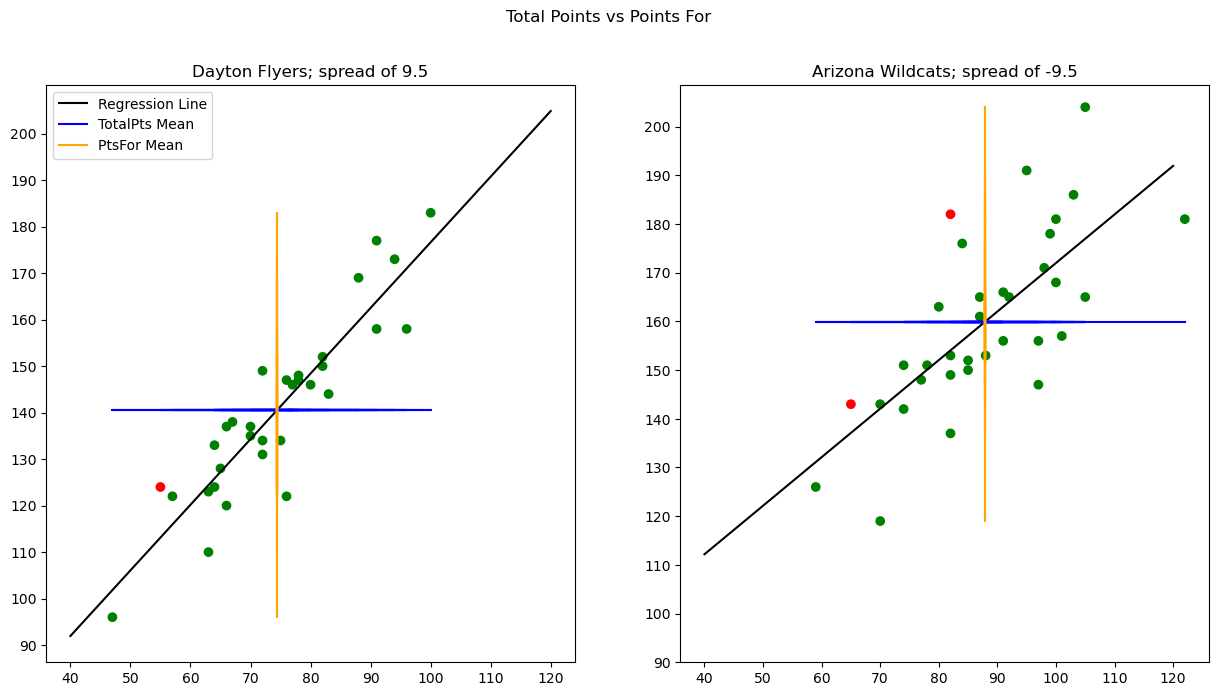

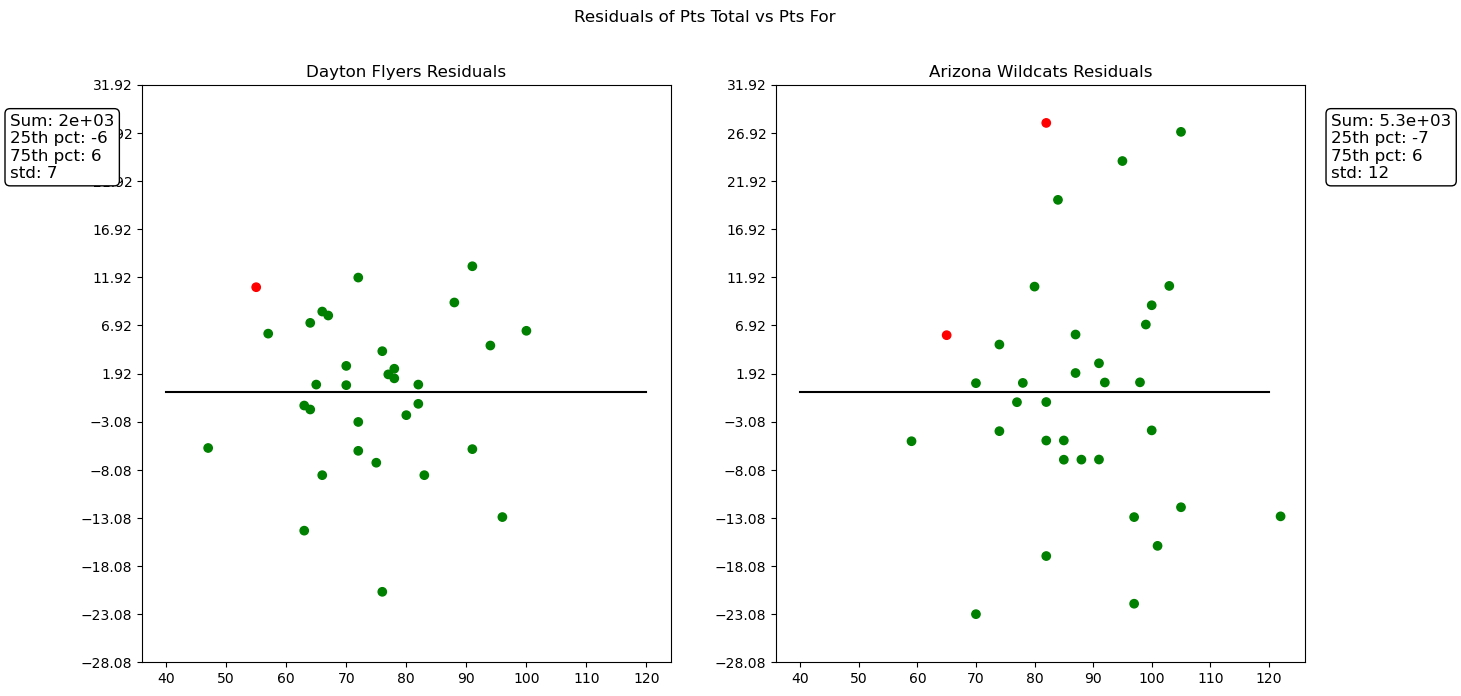

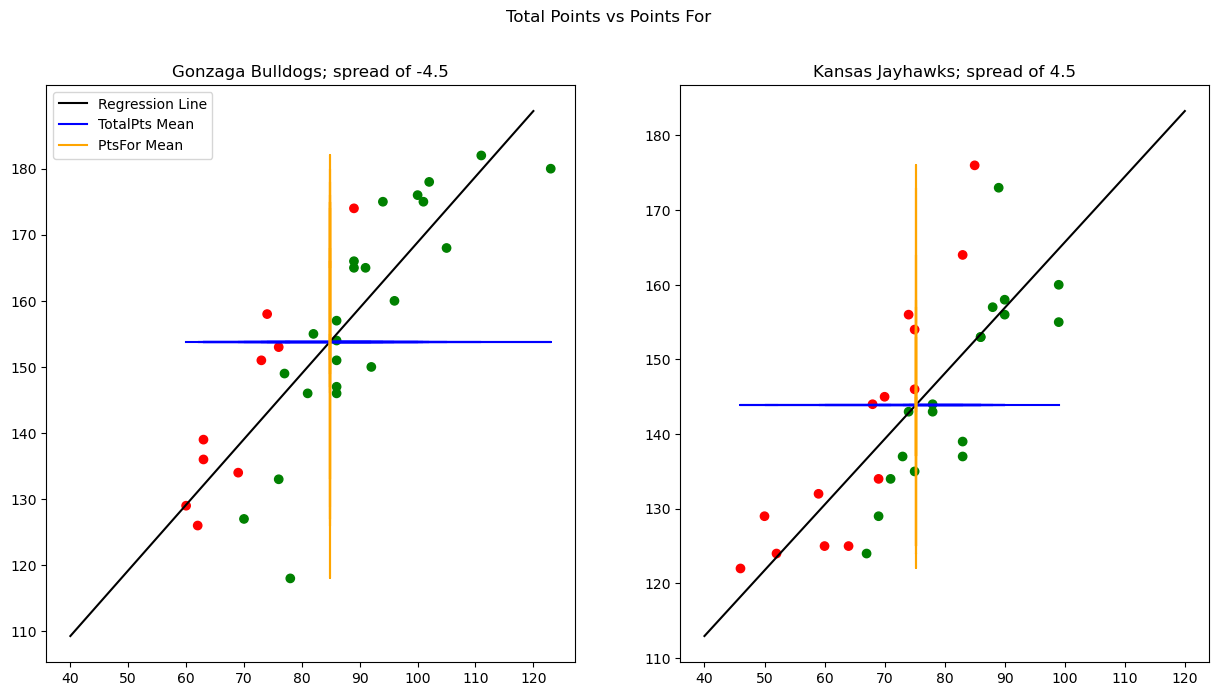

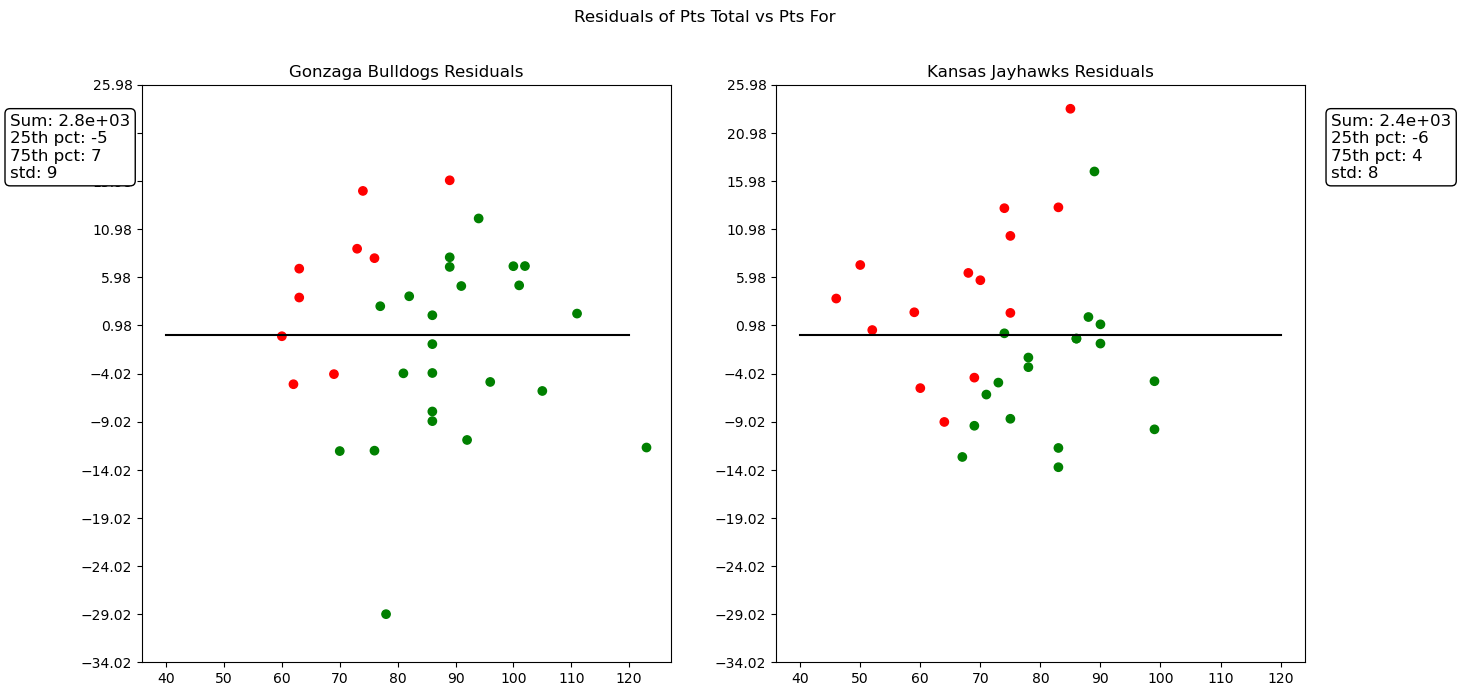

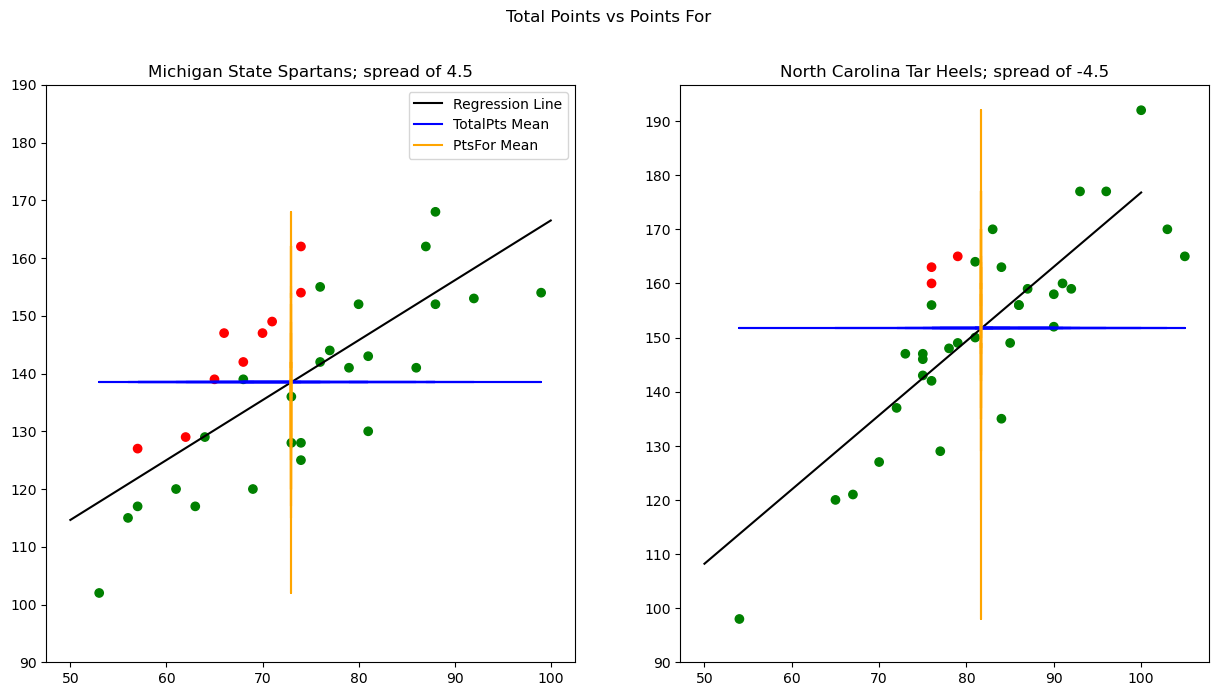

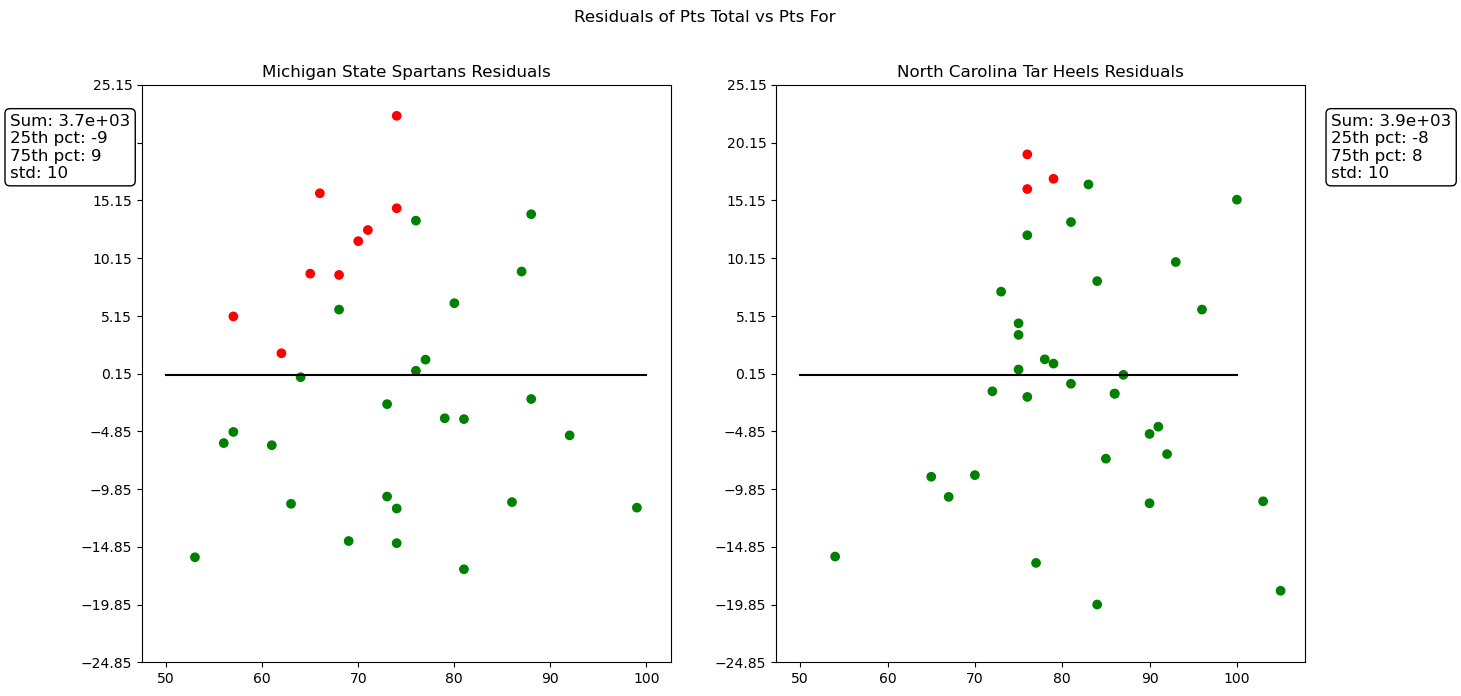

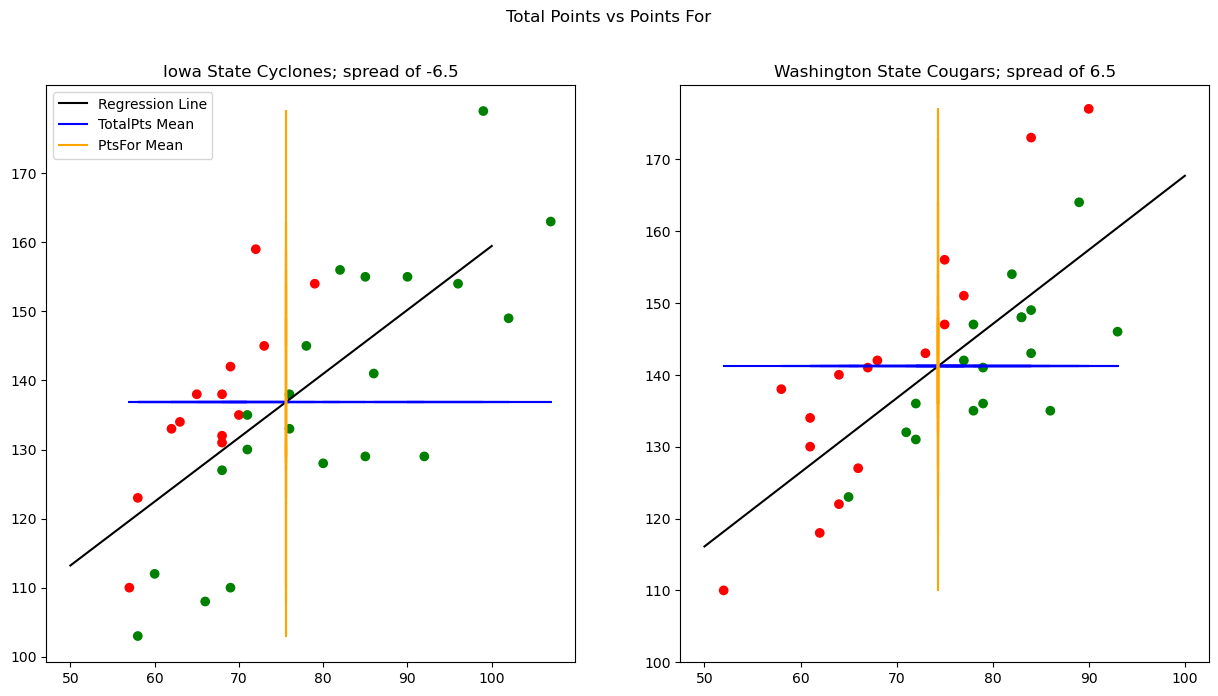

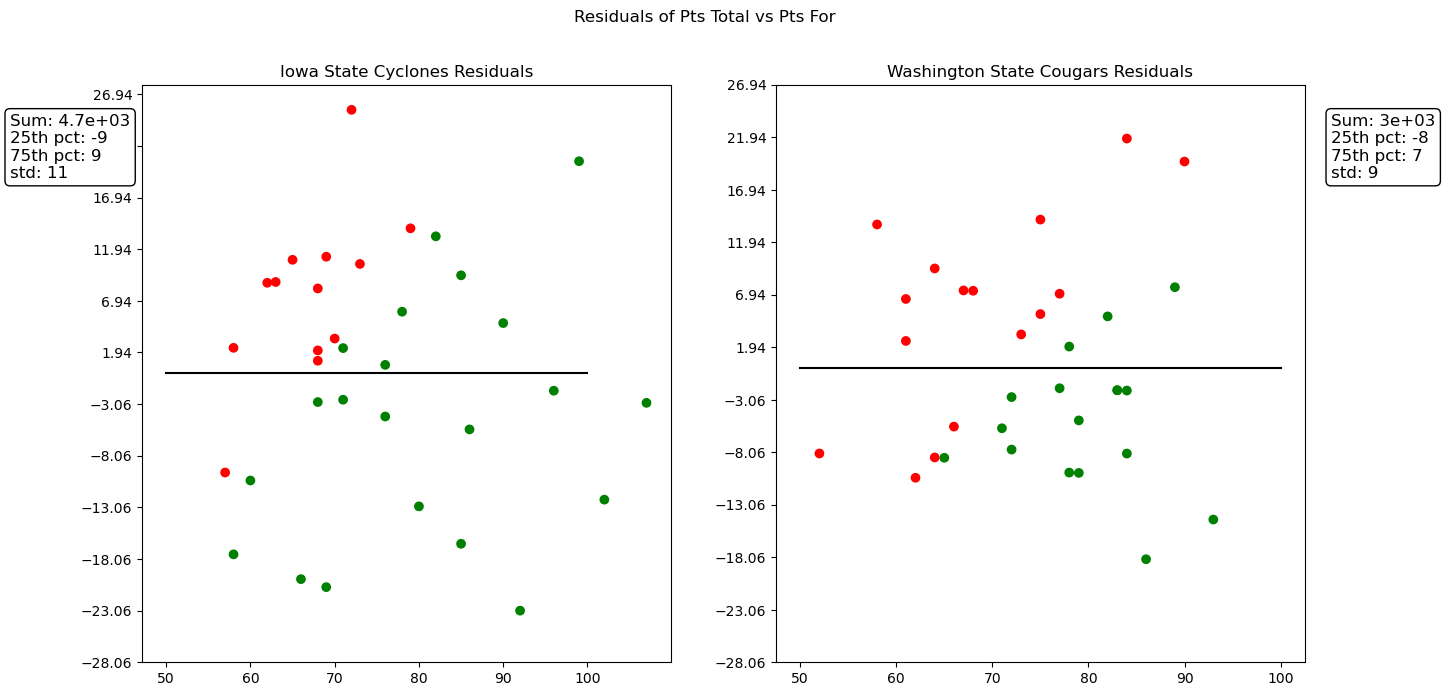

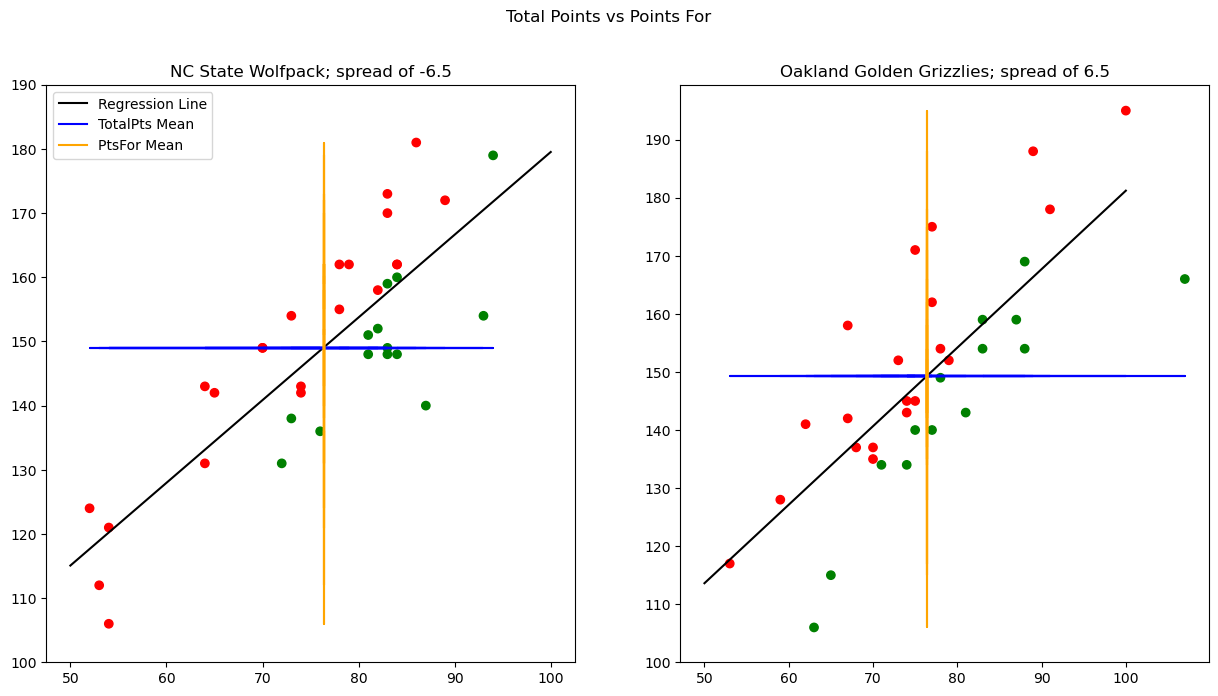

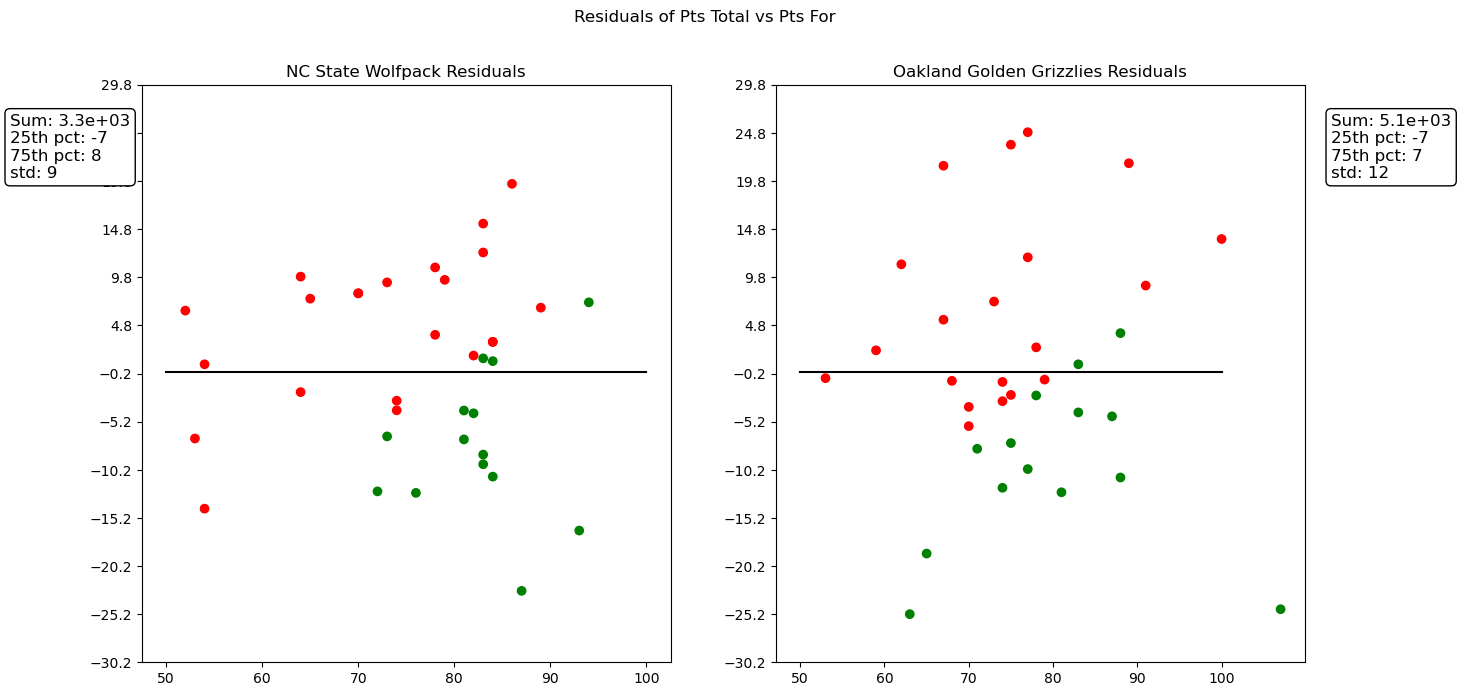

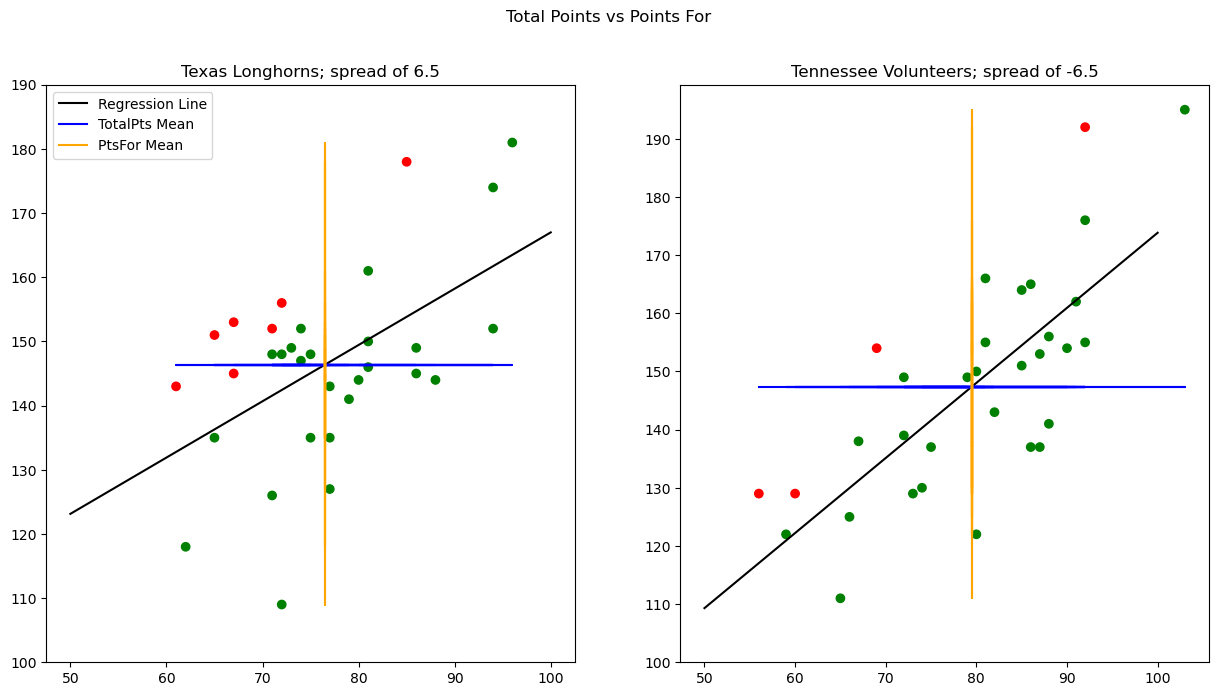

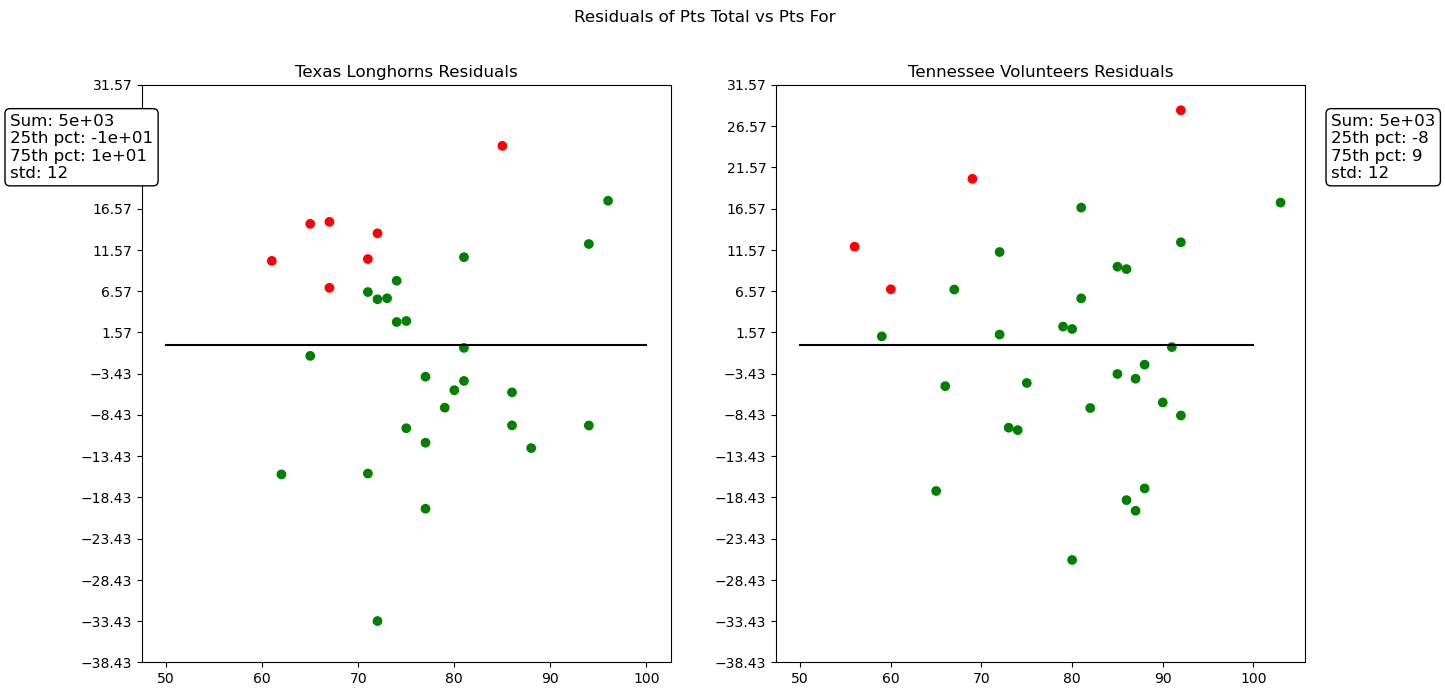

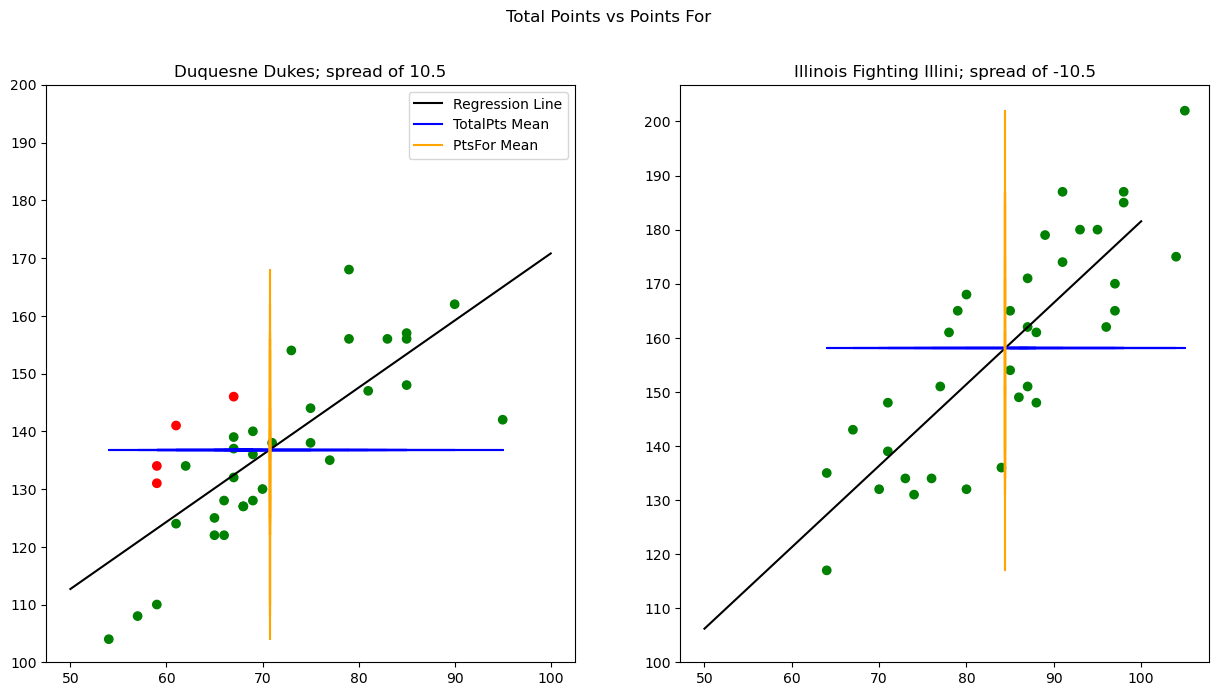

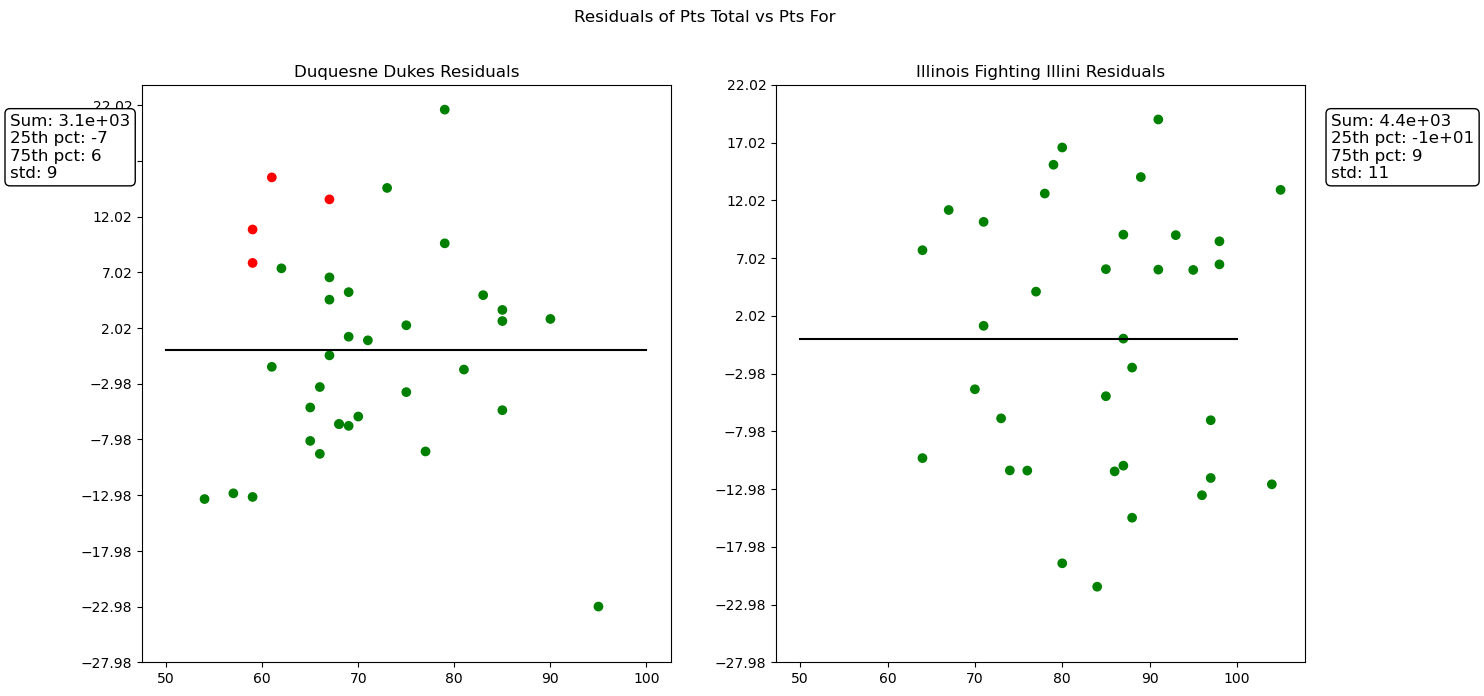

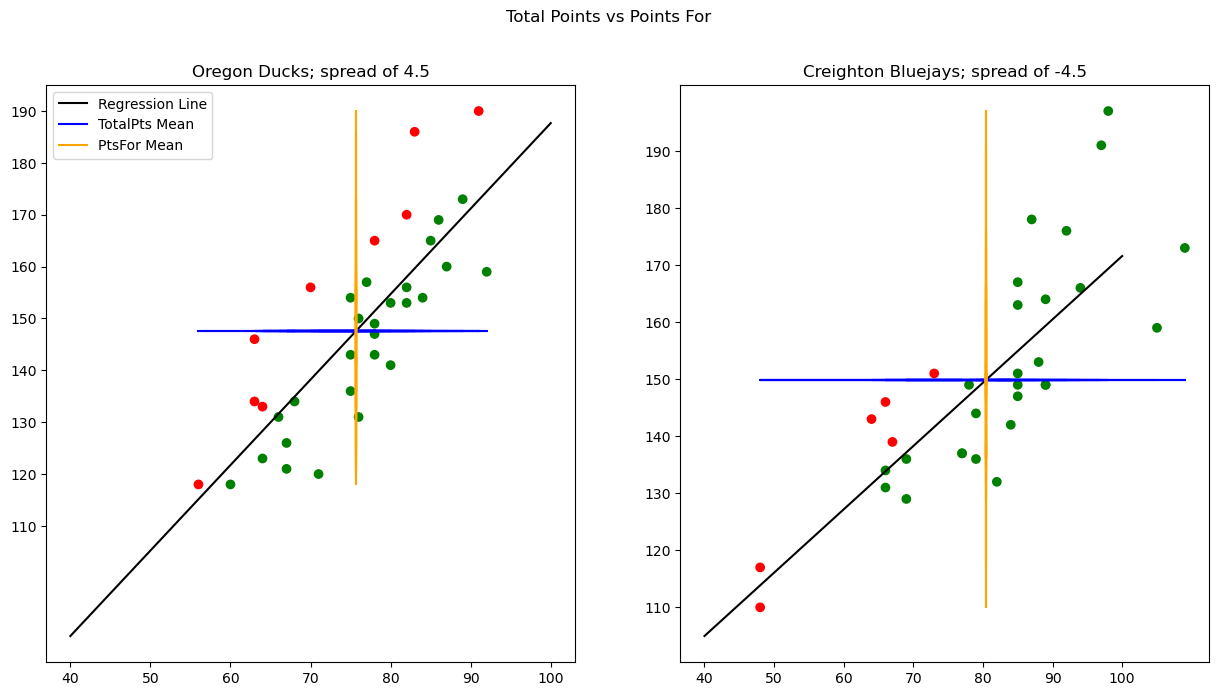

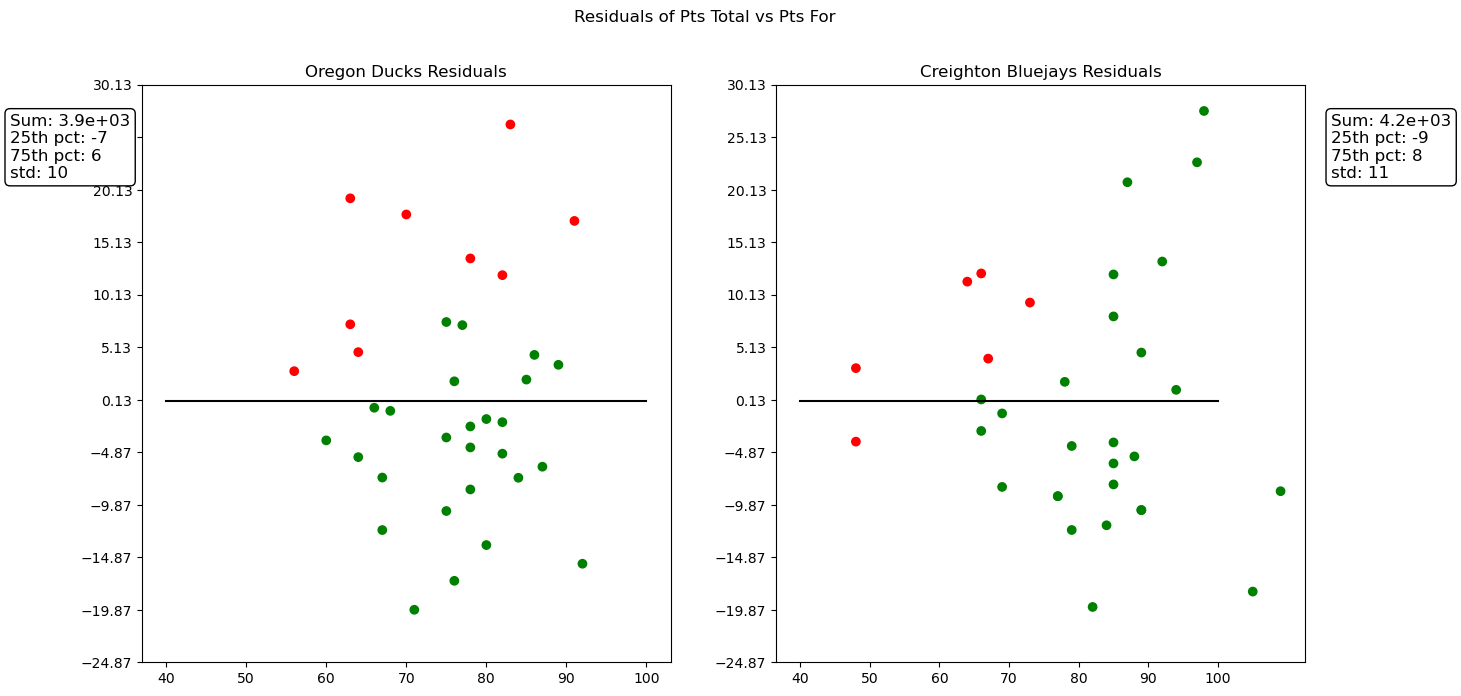

In [27]:
# Make Directory for Regression Plots
os.makedirs("PtsRegressions", exist_ok=True)
os.makedirs("Residuals", exist_ok=True)


# Messy but no big deal
for d in tst:
    keys = d.keys()
    l = len(keys)
    rfig, raxes = plt.subplots(1, l, figsize=(15, 7.5))
    sfig, saxes = plt.subplots(1, l, figsize=(15, 7.5))
    spread = 0
    rminfor = min([d[k]["team"].PtsFor.min() for k in keys])
    rmaxfor = max([d[k]["team"].PtsFor.max() for k in keys])
    rmintot = min([d[k]["team"].TotalPts.min() for k in keys])
    rmaxtot = max([d[k]["team"].TotalPts.max() for k in keys])
    rminfor = int(rminfor/10)*10
    rmintot = int(rmintot/10)*10
    rmaxfor = int(rmaxfor/10)*10
    rmaxtot = int(rmaxtot/10)*10
    ry_ticks = np.arange(rmintot, rmaxtot+10, 10)
    rx_ticks = np.arange(rminfor, rmaxfor+10, 10)

    # identify spread direction
    for k in keys:
        if k in sprd.keys():
            spread = (k, sprd[k])
    smin = None
    smax = None

    # Generate Plots for each team
    for i, (k, v) in enumerate(d.items()):
        # Generate Least Squares Linear Fit
        df = v["team"]
        fit = regress_prop(df, x="PtsFor", y="TotalPts",
                            prop="Spread", k=spread[1], build=True, show=False, prefix=k) if spread[0] == k else \
                    regress_prop(df, "PtsFor", "TotalPts", "Spread", -1*spread[1], prefix=k) # defaults for build & show are same as above
        # Generate Regression Plots
        ln = [fit[0][0]*x + fit[0][1] for x in [rminfor, rmaxfor]]
        raxes[i].plot([rminfor, rmaxfor], ln, color='Black', label="Regression Line")
        raxes[i].plot(df["PtsFor"], [df["TotalPts"].mean()]*len(df["PtsFor"]), color='Blue', label="TotalPts Mean")
        raxes[i].plot([df["PtsFor"].mean()]*len(df["TotalPts"]), df["TotalPts"], color='Orange', label="PtsFor Mean")
        raxes[i].scatter(df["PtsFor"], df["TotalPts"], color=np.where(df["Spread"] > -1*spread[1], "Green", "Red"))
        raxes[i].set_xticks(rx_ticks)
        raxes[i].set_yticks(ry_ticks)
        s = spread[1] if spread[0] == k else -1*spread[1]
        raxes[i].set_title(f'{k}; spread of {s}')

        # Generate Residuals Plots
        residuals = df["TotalPts"] - (fit[0][0]*df["PtsFor"] + fit[0][1])
        saxes[i].scatter(df["PtsFor"], residuals, color=np.where(df["Spread"] > -1*spread[1], "Green", "Red"))
        saxes[i].set_xticks(rx_ticks)
        saxes[i].set_title(f'{k} Residuals')
        saxes[i].plot([rminfor, rmaxfor], residuals.mean()*np.ones(2), color='Black', label="Residual Mean")
        # annotate the saxes[i] with residuals mean, 25th pct, 75th pct, and std
        coords = (-0.25, 0.95) if i == 0 else (1.05, 0.95)
        saxes[i].annotate(f"Sum: {'{0:.2g}'.format(fit[1][0])}\n25th pct: {'{0:.0g}'.format(residuals.quantile(.25))}\n75th pct: {'{0:.0g}'.format(residuals.quantile(.75))}\nstd: {int(residuals.std())}", xy=coords, 
                          xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle="round", fc="w"))
        
        if smin == None:
            smin = residuals.min()
            smax = residuals.max()
        else:
            smin = min(smin, residuals.min())
            smax = max(smax, residuals.max())
    saxes[0].set_yticks(np.arange(smin-5, smax+5, 5))
    saxes[1].set_yticks(np.arange(smin-5, smax+5, 5))
    sfig.suptitle("Residuals of Pts Total vs Pts For")
    rfig.suptitle("Total Points vs Points For")
    raxes[0].legend()
    tms = "_".join(keys)
    fname =f'{tms}_TotalPts_vs_PtsFor_with_{k}_spread_regression.png'
    rfig.savefig(f"PtsRegressions/{fname}")
    fname =f'{tms}_Residuals_with_{k}_spread.png'
    sfig.savefig(f"Residuals/{fname}")

In [30]:
clemson = get_team_games('Clemson Tigers')
newMexico = get_team_games('New Mexico Lobos')
alabama = get_team_games('Alabama Crimson Tide')
charleston = get_team_games('Charleston Cougars')
uab = get_team_games('UAB Blazers')
sdsu = get_team_games('San Diego State Aztecs')